
# Mental Health Condition Detection from Social Media Text

**Goal**: Build an end-to-end machine learning pipeline to detect a person's mental health condition (e.g., depression, anxiety, stress, etc.) from social media text.


## 1. Setup & Requirements

In [1]:

# Core
import os, re, sys, math, itertools, joblib, warnings, json, time, random
warnings.filterwarnings('ignore')

# Data
import numpy as np
import pandas as pd

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve, accuracy_score, precision_recall_fscore_support)

# Visualization
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

print('Python:', sys.version)
print('Pandas:', pd.__version__)


Python: 3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]
Pandas: 2.3.0


## 2. Configuration

In [2]:
DATA_PATH = 'Combined Data.csv'  

TEXT_COLUMN = 'text'   
LABEL_COLUMN = 'label'  

# Train/validation split
TEST_SIZE   = 0.2
RANDOM_STATE = 42

# Whether to drop duplicate texts
DROP_DUPLICATES = True


## 3. Load Data

In [3]:

assert os.path.exists(DATA_PATH), f'File not found: {DATA_PATH}. Please update DATA_PATH above.'
df = pd.read_csv(DATA_PATH)

print('Shape:', df.shape)
print('Columns:', df.columns.tolist())
df.head(3)


Shape: (53043, 3)
Columns: ['Unnamed: 0', 'statement', 'status']


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety


## 4. Sanity Checks & Basic Cleaning

In [5]:
TEXT_COLUMN = "statement"
LABEL_COLUMN = "status"

# Drop unnecessary index column if exists
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Keep only rows with non-null text and label
if TEXT_COLUMN not in df.columns or LABEL_COLUMN not in df.columns:
    raise ValueError(f"""
TEXT_COLUMN='{TEXT_COLUMN}' or LABEL_COLUMN='{LABEL_COLUMN}' not found.
Please open the CSV to confirm actual column names and update the config.
Columns present: {df.columns.tolist()}
""")

df = df[[TEXT_COLUMN, LABEL_COLUMN]].copy()
df = df.dropna(subset=[TEXT_COLUMN, LABEL_COLUMN])


## 5. Train / Validation Split

In [6]:

X = df[TEXT_COLUMN].astype(str).values
y = df[LABEL_COLUMN].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print('Train size:', len(X_train))
print('Val size:', len(X_val))


Train size: 42144
Val size: 10537


## 6. Text Cleaning Helper

In [7]:

def simple_clean(text):
    """Lightweight cleaner that avoids external downloads:
    - lowercasing
    - remove URLs, emails, numbers, and extra spaces
    - keep basic punctuation
    """
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)           # emails
    text = re.sub(r'[^a-z\s\.!?\,\']', ' ', text)  # keep letters and basic punctuation
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Preview cleaning on a few samples
for t in X_train[:3]:
    print('RAW  :', t[:120])
    print('CLEAN:', simple_clean(t)[:120], '\n')


RAW  : I have not tried them. I do not like the idea of needing pills to be happy my whole life. Why do not some of you guys tr
CLEAN: i have not tried them. i do not like the idea of needing pills to be happy my whole life. why do not some of you guys tr 

RAW  : it says the mayor spends only 11 percent of his time on city duties.
CLEAN: it says the mayor spends only percent of his time on city duties. 

RAW  : i m yo female i just graduated in november and been diagnosed with depression and anxiety i always thought graduating wa
CLEAN: i m yo female i just graduated in november and been diagnosed with depression and anxiety i always thought graduating wa 



## 7. Build Baseline Pipelines (TF–IDF + Models)

In [8]:

tfidf = TfidfVectorizer(
    preprocessor=simple_clean,
    tokenizer=None,            # use default tokenization
    ngram_range=(1,2),         # unigrams + bigrams
    max_features=40000,
    min_df=2,
    stop_words='english'
)

# Using class_weight='balanced' to mitigate class imbalance
logreg = LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=None)
svc    = LinearSVC(class_weight='balanced')

pipe_logreg = Pipeline([('tfidf', tfidf), ('clf', logreg)])
pipe_svc    = Pipeline([('tfidf', tfidf), ('clf', svc)])

# Quick training
pipe_logreg.fit(X_train, y_train)
pipe_svc.fit(X_train, y_train)

print('Pipelines trained.')


Pipelines trained.


## 8. Evaluation Utilities


=== TF-IDF + Logistic Regression ===

Classification Report:
                      precision    recall  f1-score   support

             Anxiety     0.7717    0.8099    0.7903       768
             Bipolar     0.7525    0.8147    0.7824       556
          Depression     0.7820    0.6193    0.6912      3081
              Normal     0.8711    0.9012    0.8859      3269
Personality disorder     0.5588    0.7070    0.6242       215
              Stress     0.5219    0.6692    0.5864       517
            Suicidal     0.6581    0.7325    0.6933      2131

            accuracy                         0.7581     10537
           macro avg     0.7023    0.7506    0.7220     10537
        weighted avg     0.7649    0.7581    0.7576     10537

Accuracy: 0.7580905381038247


<Figure size 600x600 with 0 Axes>

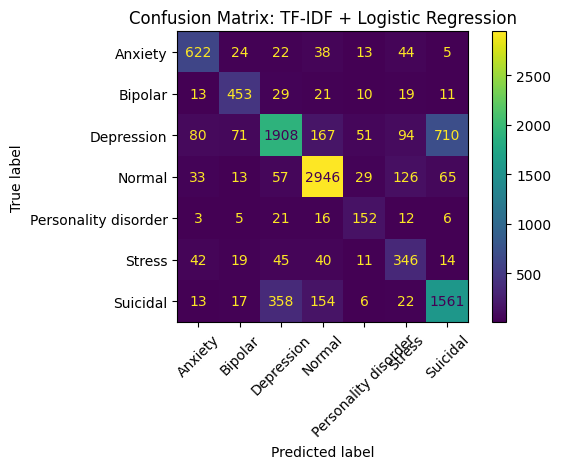


=== TF-IDF + Linear SVM ===

Classification Report:
                      precision    recall  f1-score   support

             Anxiety     0.7796    0.7969    0.7882       768
             Bipolar     0.7876    0.8004    0.7939       556
          Depression     0.7391    0.6686    0.7021      3081
              Normal     0.8559    0.9284    0.8907      3269
Personality disorder     0.7292    0.6512    0.6880       215
              Stress     0.6034    0.5416    0.5708       517
            Suicidal     0.6506    0.6710    0.6607      2131

            accuracy                         0.7594     10537
           macro avg     0.7351    0.7226    0.7278     10537
        weighted avg     0.7561    0.7594    0.7566     10537

Accuracy: 0.7594191895226345


<Figure size 600x600 with 0 Axes>

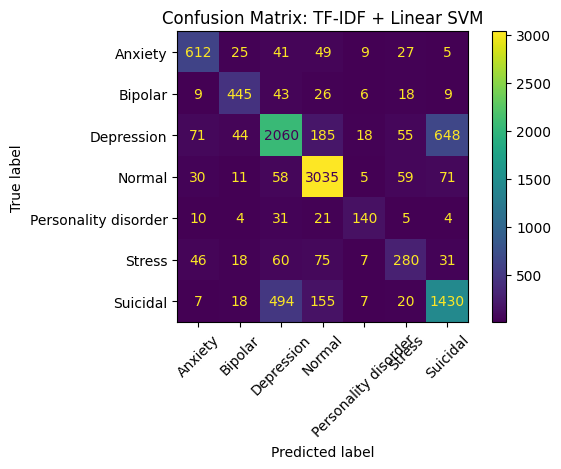

In [9]:

def evaluate_model(pipe, X_tr, y_tr, X_te, y_te, title='Model'):
    print(f'\n=== {title} ===')
    # Predictions
    y_pred = pipe.predict(X_te)
    print('\nClassification Report:')
    print(classification_report(y_te, y_pred, digits=4))
    print('Accuracy:', accuracy_score(y_te, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_te, y_pred, labels=np.unique(y_te))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_te))
    plt.figure(figsize=(6,6))
    disp.plot(values_format='d', xticks_rotation=45)
    plt.title(f'Confusion Matrix: {title}')
    plt.tight_layout()
    plt.show()

# Evaluate both
evaluate_model(pipe_logreg, X_train, y_train, X_val, y_val, title='TF-IDF + Logistic Regression')
evaluate_model(pipe_svc,    X_train, y_train, X_val, y_val, title='TF-IDF + Linear SVM')


## 9. Cross-Validation & Learning Curve

TF-IDF + Logistic Regression CV f1_macro: 0.7241 ± 0.0069
TF-IDF + Linear SVM CV f1_macro: 0.7309 ± 0.0106


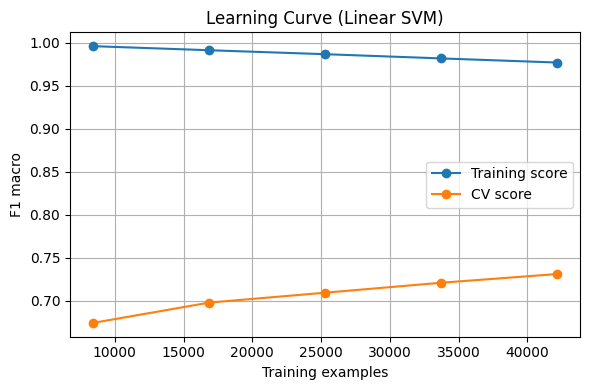

In [11]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def cv_eval(pipe, X, y, name='Model'):
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
    print(f'{name} CV f1_macro: {scores.mean():.4f} ± {scores.std():.4f}')

cv_eval(pipe_logreg, X, y, 'TF-IDF + Logistic Regression')
cv_eval(pipe_svc,    X, y, 'TF-IDF + Linear SVM')

# Learning Curve (for the best of the two; pick SVM by default)
train_sizes, train_scores, test_scores = learning_curve(
    pipe_svc, X, y, cv=cv, scoring='f1_macro',
    n_jobs=-1, train_sizes=np.linspace(0.2, 1.0, 5), shuffle=True, random_state=RANDOM_STATE
)

train_mean = train_scores.mean(axis=1)
test_mean  = test_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, marker='o', label='Training score')
plt.plot(train_sizes, test_mean, marker='o', label='CV score')
plt.xlabel('Training examples')
plt.ylabel('F1 macro')
plt.title('Learning Curve (Linear SVM)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 10. Hyperparameter Tuning (GridSearchCV)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params (SVC): {'clf__C': 0.5, 'tfidf__max_features': 80000, 'tfidf__ngram_range': (1, 2)}

=== Best TF-IDF + Linear SVM ===

Classification Report:
                      precision    recall  f1-score   support

             Anxiety     0.7794    0.8190    0.7987       768
             Bipolar     0.7919    0.8076    0.7996       556
          Depression     0.7585    0.6758    0.7147      3081
              Normal     0.8601    0.9330    0.8951      3269
Personality disorder     0.7216    0.6512    0.6846       215
              Stress     0.6090    0.5513    0.5787       517
            Suicidal     0.6656    0.6903    0.6777      2131

            accuracy                         0.7693     10537
           macro avg     0.7409    0.7326    0.7356     10537
        weighted avg     0.7664    0.7693    0.7665     10537

Accuracy: 0.7692891714909367


<Figure size 600x600 with 0 Axes>

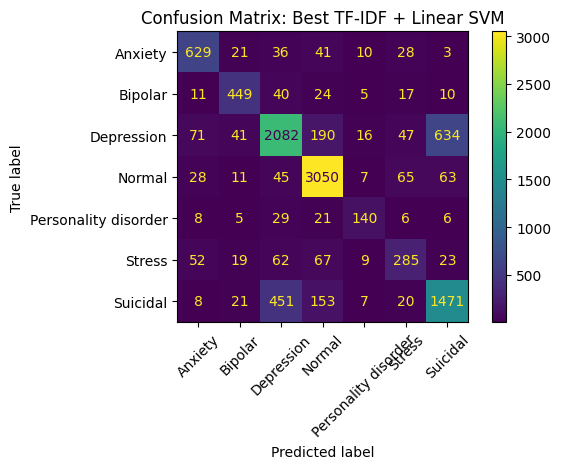

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params (LogReg): {'clf__C': 2.0, 'tfidf__max_features': 40000, 'tfidf__ngram_range': (1, 2)}

=== Best TF-IDF + Logistic Regression ===

Classification Report:
                      precision    recall  f1-score   support

             Anxiety     0.7872    0.8190    0.8028       768
             Bipolar     0.7681    0.8219    0.7941       556
          Depression     0.7723    0.6430    0.7017      3081
              Normal     0.8801    0.9095    0.8945      3269
Personality disorder     0.6255    0.7070    0.6638       215
              Stress     0.5517    0.6499    0.5968       517
            Suicidal     0.6576    0.7245    0.6894      2131

            accuracy                         0.7661     10537
           macro avg     0.7204    0.7535    0.7347     10537
        weighted avg     0.7696    0.7661    0.7654     10537

Accuracy: 0.7660624466166841


<Figure size 600x600 with 0 Axes>

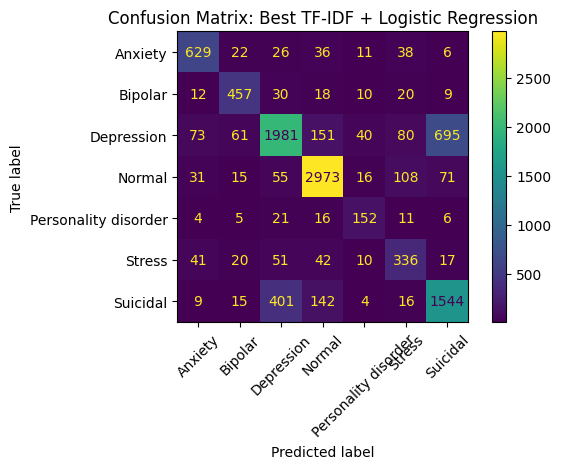

In [12]:

param_grid_svc = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_features': [20000, 40000, 80000],
    'clf__C': [0.5, 1.0, 2.0]
}

grid_svc = GridSearchCV(
    estimator=Pipeline([('tfidf', tfidf), ('clf', LinearSVC(class_weight='balanced'))]),
    param_grid=param_grid_svc, scoring='f1_macro', cv=cv, n_jobs=-1, verbose=1
)
grid_svc.fit(X_train, y_train)

print('Best params (SVC):', grid_svc.best_params_)
best_svc = grid_svc.best_estimator_

evaluate_model(best_svc, X_train, y_train, X_val, y_val, title='Best TF-IDF + Linear SVM')

# Optional: Logistic Regression grid (smaller grid to save time)
param_grid_log = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_features': [20000, 40000],
    'clf__C': [0.5, 1.0, 2.0]
}

grid_log = GridSearchCV(
    estimator=Pipeline([('tfidf', tfidf), ('clf', LogisticRegression(max_iter=2000, class_weight='balanced'))]),
    param_grid=param_grid_log, scoring='f1_macro', cv=cv, n_jobs=-1, verbose=1
)
grid_log.fit(X_train, y_train)
print('Best params (LogReg):', grid_log.best_params_)
best_log = grid_log.best_estimator_

evaluate_model(best_log, X_train, y_train, X_val, y_val, title='Best TF-IDF + Logistic Regression')


## 11. Feature Importance: Top Words per Class (Logistic Regression)

In [13]:

def show_top_terms_per_class(pipe, n=20):
    tfidf = pipe.named_steps['tfidf']
    clf   = pipe.named_steps['clf']
    if not isinstance(clf, LogisticRegression):
        print('This visualization is for LogisticRegression. Skipping.')
        return

    feature_names = np.array(tfidf.get_feature_names_out())
    classes = clf.classes_
    coefs = clf.coef_
    if coefs.ndim == 1:  # binary
        coefs = np.vstack([-coefs, coefs])

    for idx, cls in enumerate(classes):
        class_coefs = coefs[idx]
        top_idx = np.argsort(class_coefs)[-n:][::-1]
        print(f"\nTop {n} terms for class '{cls}':")
        for i in top_idx:
            print(f'{feature_names[i]}\t{class_coefs[i]:.4f}')

show_top_terms_per_class(best_log, n=20)



Top 20 terms for class 'Anxiety':
anxiety	12.6729
restless	11.2896
anxious	9.1605
worried	8.0222
nervous	7.8600
worry	5.7915
cancer	5.5941
restlessness	4.7850
health	4.5032
symptoms	4.2444
health anxiety	4.2380
freaking	4.1955
heart	3.8406
worrying	3.6474
pressure	3.6065
worries	3.4162
rabies	3.3361
healthy	3.3009
anxiously	3.2565
fear	3.2164

Top 20 terms for class 'Bipolar':
bipolar	18.1244
manic	11.7248
meds	8.3236
episode	7.8520
mania	7.7679
bp	7.5196
hypomanic	7.4060
lamictal	6.6282
lithium	6.3466
ve	5.7678
latuda	5.7392
stable	5.6072
hypomania	5.4585
seroquel	5.0602
episodes	5.0419
illness	4.7548
depakote	4.3095
mood	4.2242
abilify	4.1130
pdoc	4.0950

Top 20 terms for class 'Depression':
depression	15.5446
wa	10.0602
depressed	7.7099
doe	5.2150
ha	5.0165
http	3.9348
life	3.8611
anymore	3.5586
pression	3.5408
feel	3.3379
symptom	3.3016
parent	3.1634
le	3.1624
antidepressants	3.0494
just	2.9429
antidepressant	2.9343
know	2.8940
lost	2.8472
depressive	2.8396
ill	2.8217

Top 20 term

## 12. Save & Load the Best Model

In [17]:

# Create a folder "models" if it doesn't exist
os.makedirs("models", exist_ok=True)

MODEL_PATH = "models/mental_health_best_model.joblib"

# Save model
joblib.dump(best_svc, MODEL_PATH)
print('Saved model to:', MODEL_PATH)

# Load & test
loaded = joblib.load(MODEL_PATH)
print('Loaded model. Predicting 3 samples from validation set:')
print(loaded.predict(X_val[:3]))


Saved model to: models/mental_health_best_model.joblib
Loaded model. Predicting 3 samples from validation set:
['Suicidal' 'Bipolar' 'Suicidal']


## 13. Inference: Predict on New Text

In [33]:

def predict_condition(texts, model=None):
    if model is None:
        model = joblib.load(MODEL_PATH)
    texts = [texts] if isinstance(texts, str) else list(texts)
    preds = model.predict(texts)
    return list(zip(texts, preds))

samples = [
    "I've been feeling overwhelmed and anxious lately, can't sleep at night.",
    "Life has been really good and I'm excited about the future!",
    "I feel empty and can't focus on anything.",
    "i am so happy today",
    "Today was a stressful day",
    "Im restless for about a month",
    "My brain is about to burst, its too much pressure now on me",
    "I laughed with my friends today, but the moment I got home, the emptiness swallowed me again."
   
]
predict_condition(samples, loaded)


[("I've been feeling overwhelmed and anxious lately, can't sleep at night.",
  'Anxiety'),
 ("Life has been really good and I'm excited about the future!", 'Normal'),
 ("I feel empty and can't focus on anything.", 'Depression'),
 ('i am so happy today', 'Normal'),
 ('Today was a stressful day', 'Normal'),
 ('Im restless for about a month', 'Anxiety'),
 ('My brain is about to burst, its too much pressure now on me', 'Anxiety'),
 ('I laughed with my friends today, but the moment I got home, the emptiness swallowed me again.',
  'Normal')]